In [1]:
import utils
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms

Usando o dispositivo: cpu


In [2]:
dataset, transfor = utils.cria_dataset('cifar10')
modelo  = utils.cria_modelo('cifar10')

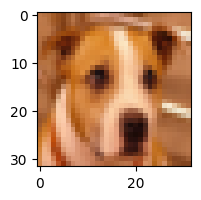

In [3]:
imagem, label = utils.get_imagem_e_label(21910, dataset, transfor, num_classes=10)
utils.mostra_imagem(imagem)

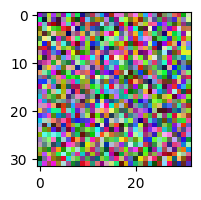

In [4]:
imagem_fake, label_fake = utils.cria_ruido(imagem.size(), label.size())
utils.mostra_imagem(imagem_fake)

# Ataque de Inversão com DLG

In [5]:
def run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados, optimizer, criterion, ataque='dlg'):
    history     = []
    to_pilimage = transforms.ToPILImage()
    loop = tqdm(range(140), desc=f"🔧 Invertendo Gradientes...",  )
    for iters in loop: 
        def closure():
            optimizer.zero_grad()

            pred_ataque = modelo(imagem_fake)
            
            if ataque == 'dlg':
                onehot_ataque = F.softmax(label_fake, dim=-1)
                
            elif ataque == 'idlg':
                onehot_ataque = torch.argmin(torch.sum(gradientes_compartilhados[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
                
            loss_ataque       = criterion(pred_ataque, onehot_ataque) 
            gradientes_ataque = torch.autograd.grad(loss_ataque, modelo.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(gradientes_ataque, gradientes_compartilhados): 
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
                
            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        current_loss = closure().item()
        loop.set_postfix(loss_inversao=current_loss)  # Atualiza a barra de progresso com a loss
        history.append(to_pilimage(imagem_fake[0].cpu()))
        
    return history


In [6]:
output_modelo    = modelo(imagem)
criterion        = utils.cross_entropy_for_onehot
logits           = criterion(output_modelo, label)
gradientes       = torch.autograd.grad(logits, modelo.parameters())

gradientes_compartilhados = list((_.detach().clone() for _ in gradientes))

🔧 Invertendo Gradientes...: 100%|██████████| 140/140 [00:24<00:00,  5.78it/s, loss_inversao=1.78e-5]


Label predito é 5.


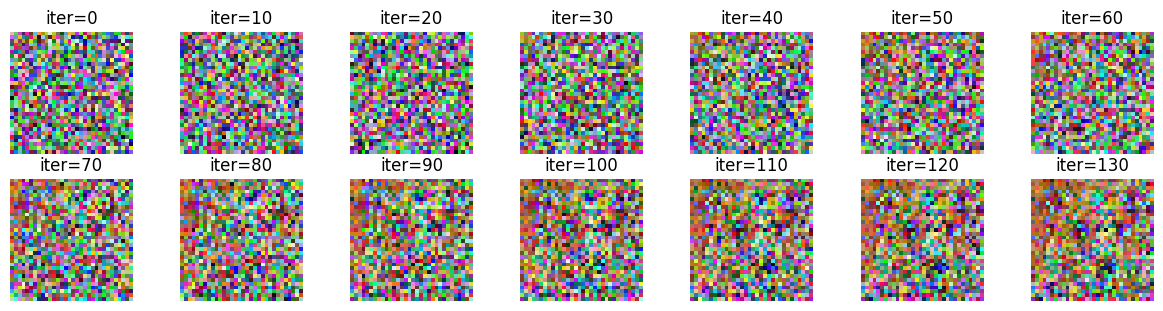

In [65]:
imagem_fake, label_fake = utils.cria_ruido(imagem.size(), label.size())

optimizer_dlg = torch.optim.LBFGS([imagem_fake, label_fake], )
loss_dlg      = torch.nn.CrossEntropyLoss(reduction='none')
historico     = run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados,
                           optimizer_dlg, loss_dlg, ataque='dlg')
utils.plot_historico_ataque(historico, label_fake)

🔧 Invertendo Gradientes...: 100%|██████████| 140/140 [00:02<00:00, 60.51it/s, loss_inversao=501]


Label predito é 4.


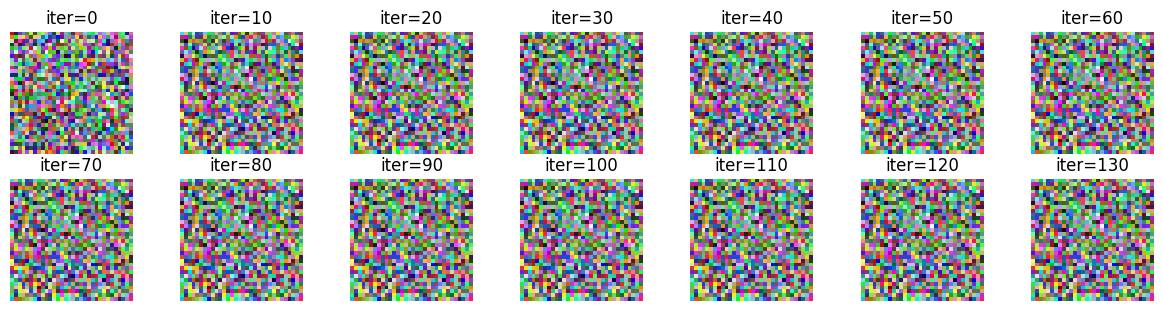

In [8]:
imagem_fake, label_fake = utils.cria_ruido(imagem.size(), label.size())
optimizer_dlg = torch.optim.LBFGS([imagem_fake], )
loss_dlg      = torch.nn.CrossEntropyLoss(reduction='none')
historico     = run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados,
                           optimizer_dlg, loss_dlg, ataque='idlg')
utils.plot_historico_ataque(historico, label_fake)

In [ ]:
import torch.nn.utils.prune as prune

def prune_model(model, amount=0.1):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.random_unstructured(module, name="weight", amount=amount)
            print(f"Pruned {name}")
            
            


Pruned body.0
Pruned body.2
Pruned body.4
Pruned body.6
Pruned fc.0


In [63]:
modelo           = utils.cria_modelo('cifar10')
prune_model(modelo, 0.4)
output_modelo    = modelo(imagem)
criterion        = utils.cross_entropy_for_onehot
logits           = criterion(output_modelo, label)
gradientes       = torch.autograd.grad(logits, modelo.parameters())

gradientes_compartilhados = list((_.detach().clone() for _ in gradientes))

Pruned body.0
Pruned body.2
Pruned body.4
Pruned body.6
Pruned fc.0


In [64]:
gradientes_compartilhados

[tensor([ 0.0445, -0.0181,  0.0259,  0.0056,  0.0109, -0.0148, -0.0300,  0.0768,
         -0.0679,  0.0564, -0.0183, -0.0271]),
 tensor([[[[ 5.9331e-02,  6.1453e-02,  0.0000e+00,  2.8302e-02,  2.2342e-02],
           [ 6.6852e-02,  7.0376e-02,  4.7990e-02,  3.3184e-02,  2.6049e-02],
           [ 6.6821e-02,  0.0000e+00,  4.1332e-02,  2.9303e-02,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  4.8701e-02,  0.0000e+00,  2.8156e-02],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.3935e-02,  2.8049e-02]],
 
          [[ 3.9618e-02,  4.3687e-02,  3.6456e-02,  2.5134e-02,  2.0487e-02],
           [ 0.0000e+00,  5.0483e-02,  0.0000e+00,  3.1714e-02,  0.0000e+00],
           [ 5.0414e-02,  5.1013e-02,  3.3265e-02,  2.5254e-02,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  5.8720e-02,  3.9377e-02,  0.0000e+00,  0.0000e+00]],
 
          [[ 2.2779e-02,  2.6939e-02,  2.5134e-02,  0.0000e+00,  1.5267e-02],
        